# Traffic Accident Severity Prediction Notebook

## Traffic Accident Severity Prediction

This notebook demonstrates the development of predictive models for classifying the severity of road traffic accidents using an open-access dataset.  
The workflow includes:

- **Data loading & preprocessing:** Handling missing values, encoding categorical variables, and feature scaling.  
- **Exploratory analysis:** Previewing the dataset and examining key attributes.  
- **Modeling:** Training multiple classification models (Logistic Regression, Decision Tree, Random Forest, SVM, XGBoost).  
- **Evaluation:** Using metrics such as accuracy, precision, recall, F1-score, cross-validation, and ROC-AUC curves to compare performance.    

The goal is to identify the most effective modelling approach and provide insights that can support targeted road safety strategies.

---

### About Dataset
#### Traffic Accident Prediction Dataset

This dataset contains data designed to predict the occurrence and severity of traffic accidents based on various factors affecting road conditions, driver behaviour, and traffic situations.

---

### Features

- **Weather:** The impact of weather conditions on accidents.  
  - Clear → No adverse conditions.  
  - Rainy → Increased accident chance.  
  - Foggy → Reduced visibility.  
  - Snowy → Slippery roads, higher risk.  
  - Stormy → Hazardous conditions.  

- **Road_Type:** The type of road influences accident probability.  
  - Highway → High-speed, often severe accidents.  
  - City Road → More traffic, lower speeds.  
  - Rural Road → Fewer vehicles, variable risk.  
  - Mountain Road → Curves & elevation changes, higher risk.  

- **Time_of_Day:** When the accident occurs.  
  - Morning, Afternoon, Evening, Night.  

- **Traffic_Density:** Level of traffic on the road.  
  - 0: Low density  
  - 1: Moderate density  
  - 2: High density  

- **Speed_Limit:** Maximum allowed speed.  

- **Number_of_Vehicles:** Vehicles involved (1–5).  

- **Driver_Alcohol:** Alcohol consumption.  
  - 0: No alcohol  
  - 1: Consumed alcohol  

- **Accident_Severity (Target):** Accident impact.  
  - Low: Minor  
  - Moderate: Moderate injuries/damage  
  - High: Severe injuries/damage  

- **Road_Condition:** State of road surface.  
  - Dry, Wet, Icy, Under Construction  

- **Vehicle_Type:** Type of vehicle involved.  
  - Car, Truck, Motorcycle, Bus  

- **Driver_Age:** Age of driver (18–70).  

- **Driver_Experience:** Years of experience (0–50).  

- **Road_Light_Condition:** Lighting conditions.  
  - Daylight, Artificial Light, No Light  


### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
!pip install xgboost


from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize, OneHotEncoder
from sklearn.metrics import (classification_report, confusion_matrix,ConfusionMatrixDisplay, 
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

from itertools import cycle

from xgboost import XGBClassifier

!pip install xgboost optuna imbalanced-learn scikit-learn
import optuna
from xgboost import XGBClassifier

## 2. Load Dataset

In [2]:
df = pd.read_csv("dataset_traffic_accident_prediction1.csv")
print("Shape:", df.shape)

Shape: (840, 14)


In [3]:
print(df.head())

  Weather   Road_Type Time_of_Day  Traffic_Density  Speed_Limit  \
0   Rainy   City Road     Morning              1.0        100.0   
1   Clear  Rural Road       Night              NaN        120.0   
2   Rainy     Highway     Evening              1.0         60.0   
3   Clear   City Road   Afternoon              2.0         60.0   
4   Rainy     Highway     Morning              1.0        195.0   

   Number_of_Vehicles  Driver_Alcohol Accident_Severity      Road_Condition  \
0                 5.0             0.0               NaN                 Wet   
1                 3.0             0.0          Moderate                 Wet   
2                 4.0             0.0               Low                 Icy   
3                 3.0             0.0               Low  Under Construction   
4                11.0             0.0               Low                 Dry   

  Vehicle_Type  Driver_Age  Driver_Experience Road_Light_Condition  Accident  
0          Car        51.0               48

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Weather               798 non-null    object 
 1   Road_Type             798 non-null    object 
 2   Time_of_Day           798 non-null    object 
 3   Traffic_Density       798 non-null    float64
 4   Speed_Limit           798 non-null    float64
 5   Number_of_Vehicles    798 non-null    float64
 6   Driver_Alcohol        798 non-null    float64
 7   Accident_Severity     798 non-null    object 
 8   Road_Condition        798 non-null    object 
 9   Vehicle_Type          798 non-null    object 
 10  Driver_Age            798 non-null    float64
 11  Driver_Experience     798 non-null    float64
 12  Road_Light_Condition  798 non-null    object 
 13  Accident              798 non-null    float64
dtypes: float64(7), object(7)
memory usage: 92.0+ KB
None


### Descriptives

In [5]:
df.describe()

,Traffic_Density,Speed_Limit,Number_of_Vehicles,Driver_Alcohol,Driver_Age,Driver_Experience,Accident
count,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000,798.000000
mean,1.001253,71.050125,3.286967,0.160401,43.259398,38.981203,0.299499
std,0.784894,32.052458,2.017267,0.367208,15.129856,15.273201,0.458326
min,0.000000,30.000000,1.000000,0.000000,18.000000,9.000000,0.000000
25%,0.000000,50.000000,2.000000,0.000000,30.000000,26.000000,0.000000
50%,1.000000,60.000000,3.000000,0.000000,43.000000,39.000000,0.000000
75%,2.000000,80.000000,4.000000,0.000000,56.000000,52.750000,1.000000
max,2.000000,213.000000,14.000000,1.000000,69.000000,69.000000,1.000000


## 3. Data Preprocessing

### Drop duplicates

In [6]:
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

Duplicates before: 14
Duplicates after: 0


In [7]:
df

,Weather,Road_Type,Time_of_Day,Traffic_Density,Speed_Limit,Number_of_Vehicles,Driver_Alcohol,Accident_Severity,Road_Condition,Vehicle_Type,Driver_Age,Driver_Experience,Road_Light_Condition,Accident
0,Rainy,City Road,Morning,1.0,100.0,5.0,0.0,NaN,Wet,Car,51.0,48.0,Artificial Light,0.0
1,Clear,Rural Road,Night,NaN,120.0,3.0,0.0,Moderate,Wet,Truck,49.0,43.0,Artificial Light,0.0
2,Rainy,Highway,Evening,1.0,60.0,4.0,0.0,Low,Icy,Car,54.0,52.0,Artificial Light,0.0
3,Clear,City Road,Afternoon,2.0,60.0,3.0,0.0,Low,Under Construction,Bus,34.0,31.0,Daylight,0.0
4,Rainy,Highway,Morning,1.0,195.0,11.0,0.0,Low,Dry,Car,62.0,55.0,Artificial Light,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,Clear,Highway,Night,2.0,30.0,4.0,0.0,Low,Dry,Car,23.0,15.0,Daylight,0.0
836,Rainy,Rural Road,Evening,2.0,60.0,4.0,0.0,Low,Dry,Motorcycle,52.0,46.0,Daylight,1.0
837,Foggy,Highway,Evening,NaN,30.0,4.0,1.0,High,Dry,Car,NaN,34.0,Artificial Light,NaN
838,Foggy,Highway,Afternoon,2.0,60.0,3.0,0.0,Low,Dry,Car,25.0,19.0,Artificial Light,0.0


### Handle missing values 

In [8]:
print("Missing values per column before:\n", df.isnull().sum())
df = df.dropna()
print("Missing values per column after:\n", df.isnull().sum())

Missing values per column before:
 Weather                 42
Road_Type               42
Time_of_Day             41
Traffic_Density         42
Speed_Limit             42
Number_of_Vehicles      42
Driver_Alcohol          42
Accident_Severity       41
Road_Condition          42
Vehicle_Type            42
Driver_Age              42
Driver_Experience       42
Road_Light_Condition    42
Accident                42
dtype: int64
Missing values per column after:
 Weather                 0
Road_Type               0
Time_of_Day             0
Traffic_Density         0
Speed_Limit             0
Number_of_Vehicles      0
Driver_Alcohol          0
Accident_Severity       0
Road_Condition          0
Vehicle_Type            0
Driver_Age              0
Driver_Experience       0
Road_Light_Condition    0
Accident                0
dtype: int64


In [9]:
df

,Weather,Road_Type,Time_of_Day,Traffic_Density,Speed_Limit,Number_of_Vehicles,Driver_Alcohol,Accident_Severity,Road_Condition,Vehicle_Type,Driver_Age,Driver_Experience,Road_Light_Condition,Accident
2,Rainy,Highway,Evening,1.0,60.0,4.0,0.0,Low,Icy,Car,54.0,52.0,Artificial Light,0.0
3,Clear,City Road,Afternoon,2.0,60.0,3.0,0.0,Low,Under Construction,Bus,34.0,31.0,Daylight,0.0
4,Rainy,Highway,Morning,1.0,195.0,11.0,0.0,Low,Dry,Car,62.0,55.0,Artificial Light,1.0
6,Foggy,Highway,Afternoon,0.0,60.0,4.0,0.0,Low,Dry,Truck,27.0,26.0,Daylight,1.0
7,Rainy,City Road,Afternoon,0.0,60.0,4.0,0.0,Low,Dry,Car,29.0,22.0,Artificial Light,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,Clear,Highway,Morning,1.0,100.0,2.0,0.0,Moderate,Wet,Car,56.0,48.0,Artificial Light,1.0
835,Clear,Highway,Night,2.0,30.0,4.0,0.0,Low,Dry,Car,23.0,15.0,Daylight,0.0
836,Rainy,Rural Road,Evening,2.0,60.0,4.0,0.0,Low,Dry,Motorcycle,52.0,46.0,Daylight,1.0
838,Foggy,Highway,Afternoon,2.0,60.0,3.0,0.0,Low,Dry,Car,25.0,19.0,Artificial Light,0.0


## 4. Encode categorical features & Scale numeric features while keeping a copy of original data

In [10]:
# Define target and features
target_col = "Accident_Severity"
y = df[target_col].map({"Low": 0, "Moderate": 1, "High": 2})  # Ordinal encoding for target

# Drop target from features
X = df.drop(columns=[target_col])

# Define categorical & numeric columns
binary_cols = ["Driver_Alcohol"]  # already numeric (0/1)
ordinal_cols = ["Traffic_Density"]  # ordinal categories (0,1,2)
onehot_cols = [
    "Weather", "Road_Type", "Road_Condition",
    "Vehicle_Type", "Road_Light_Condition", "Time_of_Day"
]
numeric_cols = ["Speed_Limit", "Number_of_Vehicles", "Driver_Age", "Driver_Experience"]

# Preprocessor: scale numeric + encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),               # scale numeric features
        ("onehot", OneHotEncoder(drop="first"), onehot_cols),  # one-hot categorical
        ("ord", "passthrough", ordinal_cols),                  # keep ordinal as is
        ("bin", "passthrough", binary_cols)                    # keep binary as is
    ]
)

# Transform features
X_processed = preprocessor.fit_transform(X)

print("Preprocessing complete.")
print("Shape before:", X.shape, " | Shape after:", X_processed.shape)


Preprocessing complete.
Shape before: (393, 13)  | Shape after: (393, 24)


## 4. Define Features & Target

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)
print("Train and test sets created.")

Train and test sets created.


## 5. Exploratory Data Analysis 

### 1. Target variable distribution

C:\Users\user\AppData\Local\Temp\ipykernel_13552\625776640.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Accident_Severity", palette="Set2")


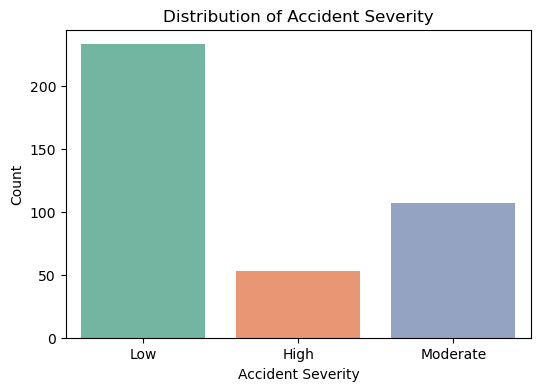

This shows the balance of accident severity classes in the dataset.


In [12]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Accident_Severity", palette="Set2")
plt.title("Distribution of Accident Severity")
plt.xlabel("Accident Severity")
plt.ylabel("Count")
plt.show()
print("This shows the balance of accident severity classes in the dataset.")

### 2. Weather conditions vs. severity

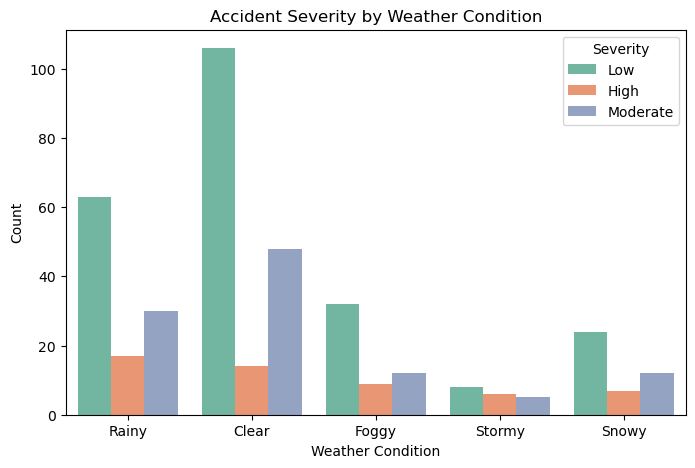

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Weather", hue="Accident_Severity", palette="Set2")
plt.title("Accident Severity by Weather Condition")
plt.xlabel("Weather Condition")

plt.ylabel("Count")
plt.legend(title="Severity")
plt.show()


### 3. Road type vs. severity

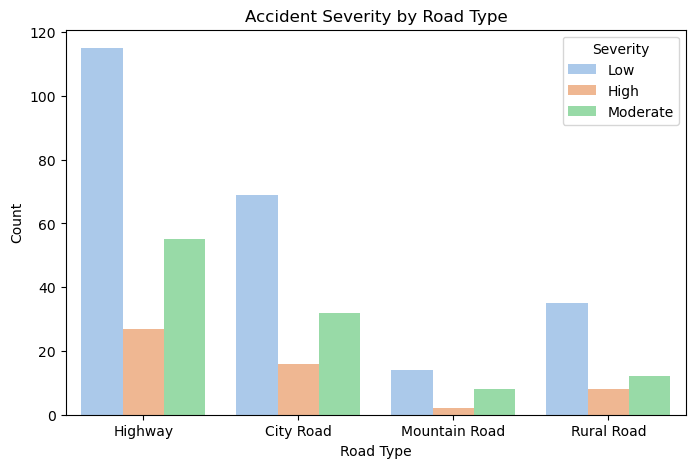

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Road_Type", hue="Accident_Severity", palette="pastel")
plt.title("Accident Severity by Road Type")
plt.xlabel("Road Type")
plt.ylabel("Count")
plt.legend(title="Severity")
plt.show()

### 4. Time of day distribution

C:\Users\user\AppData\Local\Temp\ipykernel_13552\2485145942.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


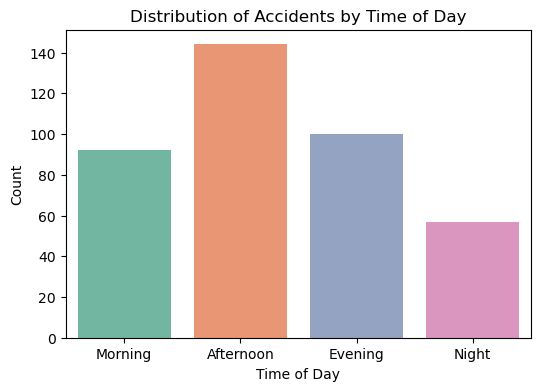

Accidents are often more frequent in Afternoon and evenings.


In [15]:
# Decode Time_of_Day
plt.figure(figsize=(6,4))
sns.countplot(
    data=df, 
    x="Time_of_Day", 
    palette="Set2", 
    order=["Morning","Afternoon", "Evening" ,"Night"]
)
plt.title("Distribution of Accidents by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.show()

print("Accidents are often more frequent in Afternoon and evenings.")

### 5. Correlation heatmap for numeric variables

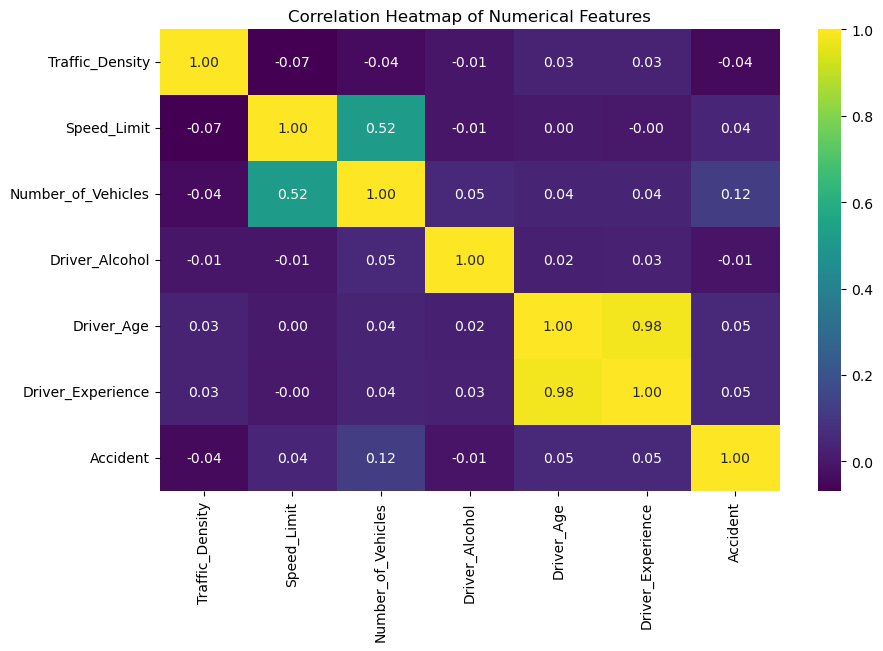

The heatmap highlights linear relationships between numeric variables and accident severity.


In [16]:
plt.figure(figsize=(10,6))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()
print("The heatmap highlights linear relationships between numeric variables and accident severity.")

### 6. Driver Age distribution by severity

C:\Users\user\AppData\Local\Temp\ipykernel_13552\1586429600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Accident_Severity", y="Driver_Age", palette="pastel")


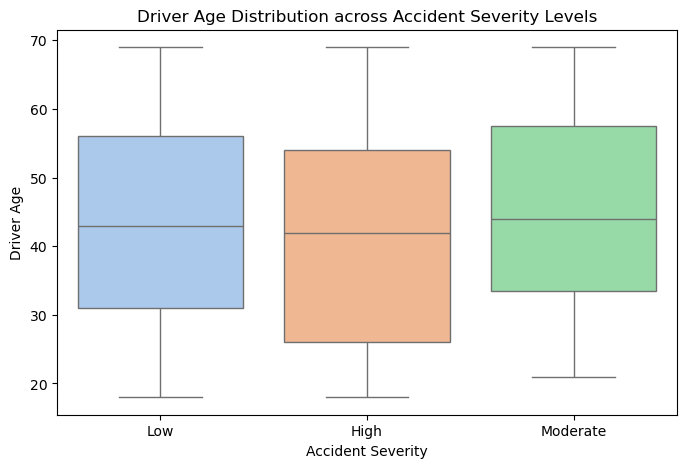

Younger and very old drivers may show higher accident severity risks compared to middle-aged drivers.


In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Accident_Severity", y="Driver_Age", palette="pastel")
plt.title("Driver Age Distribution across Accident Severity Levels")
plt.xlabel("Accident Severity")
plt.ylabel("Driver Age")
plt.show()
print("Younger and very old drivers may show higher accident severity risks compared to middle-aged drivers.")

### 7. Traffic density impact

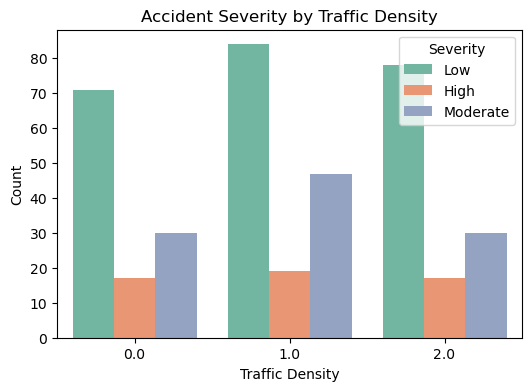

High traffic density is expected to be associated with more frequent and possibly more severe accidents.


In [18]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Traffic_Density", hue="Accident_Severity", palette="Set2")
plt.title("Accident Severity by Traffic Density")
plt.xlabel("Traffic Density")
plt.ylabel("Count")
plt.legend(title="Severity")
plt.show()
print("High traffic density is expected to be associated with more frequent and possibly more severe accidents.")

### 6. Apply SMOTE on training data

In [19]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("y_train distribution after SMOTE:", y_train_res.value_counts().to_dict())
print("Final train shape:", X_train_res.shape, " | Test shape:", X_test.shape)

y_train distribution after SMOTE: {0: 163, 2: 163, 1: 163}
Final train shape: (489, 24)  | Test shape: (118, 24)


## 7. Model Development + CV + Test Metrics

### Fit on train, evaluate on test

In [20]:

# 1. Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_processed, y)

# 2. Split data (train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# 3. Create a validation set from train data for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


===== Logistic Regression =====
              precision    recall  f1-score   support

         Low       0.44      0.34      0.39        70
    Moderate       0.50      0.59      0.54        70
        High       0.50      0.53      0.51        70

    accuracy                           0.49       210
   macro avg       0.48      0.49      0.48       210
weighted avg       0.48      0.49      0.48       210



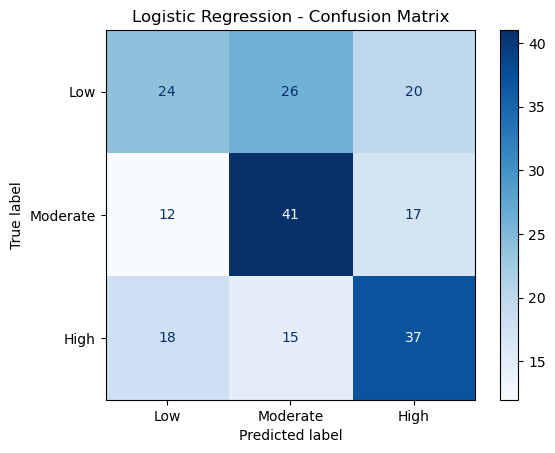


===== Decision Tree =====
              precision    recall  f1-score   support

         Low       0.68      0.66      0.67        70
    Moderate       0.69      0.71      0.70        70
        High       0.71      0.71      0.71        70

    accuracy                           0.70       210
   macro avg       0.70      0.70      0.70       210
weighted avg       0.70      0.70      0.70       210



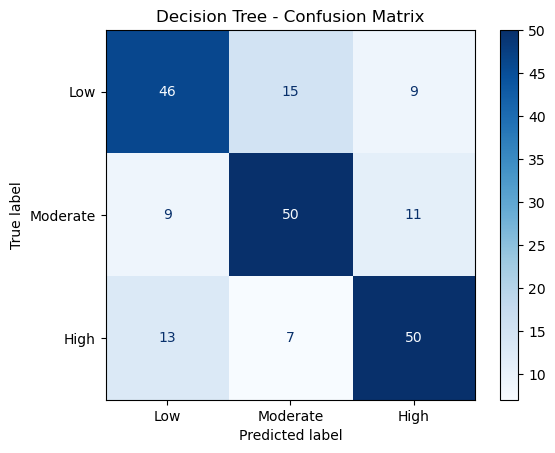


===== Random Forest =====
              precision    recall  f1-score   support

         Low       0.72      0.83      0.77        70
    Moderate       0.78      0.70      0.74        70
        High       0.88      0.84      0.86        70

    accuracy                           0.79       210
   macro avg       0.79      0.79      0.79       210
weighted avg       0.79      0.79      0.79       210



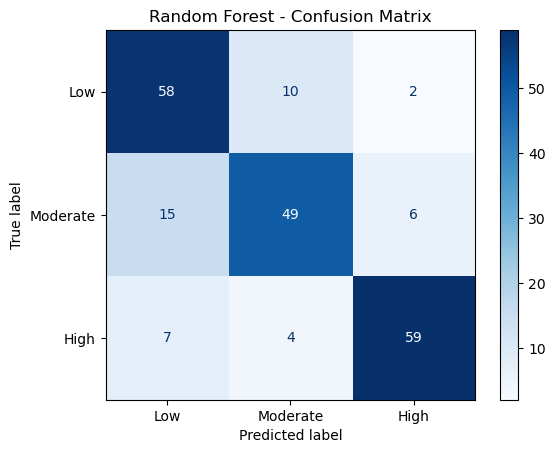


===== SVM =====
              precision    recall  f1-score   support

         Low       0.59      0.59      0.59        70
    Moderate       0.65      0.64      0.65        70
        High       0.72      0.74      0.73        70

    accuracy                           0.66       210
   macro avg       0.66      0.66      0.66       210
weighted avg       0.66      0.66      0.66       210



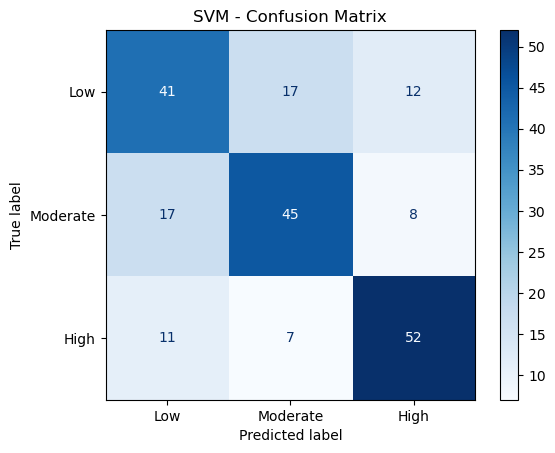


===== XGBoost =====
              precision    recall  f1-score   support

         Low       0.77      0.84      0.80        70
    Moderate       0.79      0.76      0.77        70
        High       0.88      0.83      0.85        70

    accuracy                           0.81       210
   macro avg       0.81      0.81      0.81       210
weighted avg       0.81      0.81      0.81       210



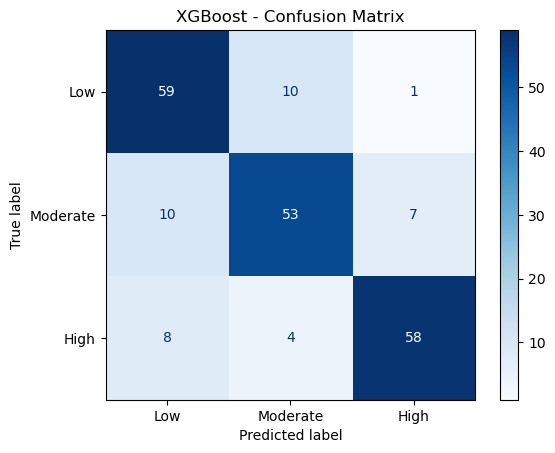


Model Accuracy Comparison:
Logistic Regression: 0.4857
Decision Tree: 0.6952
Random Forest: 0.7905
SVM: 0.6571
XGBoost: 0.8095


In [21]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        learning_rate=0.001,
        n_estimators=1000,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    )
}


results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    # Metrics
    print(classification_report(y_test, y_pred, target_names=["Low", "Moderate", "High"]))
    
    # Store accuracy
    results[name] = accuracy_score(y_test, y_pred)
    
    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=["Low", "Moderate", "High"], cmap="Blues", values_format="d"
    )
    disp.ax_.set_title(f"{name} - Confusion Matrix")
    plt.show()

# Print summary
print("\nModel Accuracy Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


### Cross-validation (StratifiedKFold)

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    print(f"\n===== {name} Cross-Validation =====")
    
    acc = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1_macro")
    
    cv_results[name] = {
        "CV Accuracy Mean": acc.mean(),
        "CV F1 Macro Mean": f1.mean()
    }
    
    print(f"Cross-Validation Accuracy: {acc.mean():.4f} (+/- {acc.std():.4f})")
    print(f"Cross-Validation F1 Macro: {f1.mean():.4f} (+/- {f1.std():.4f})")


===== Logistic Regression Cross-Validation =====
Cross-Validation Accuracy: 0.4131 (+/- 0.0151)
Cross-Validation F1 Macro: 0.4041 (+/- 0.0168)

===== Decision Tree Cross-Validation =====
Cross-Validation Accuracy: 0.5910 (+/- 0.0555)
Cross-Validation F1 Macro: 0.5863 (+/- 0.0531)

===== Random Forest Cross-Validation =====
Cross-Validation Accuracy: 0.6931 (+/- 0.0580)
Cross-Validation F1 Macro: 0.6913 (+/- 0.0580)

===== SVM Cross-Validation =====
Cross-Validation Accuracy: 0.5521 (+/- 0.0345)
Cross-Validation F1 Macro: 0.5488 (+/- 0.0353)

===== XGBoost Cross-Validation =====
Cross-Validation Accuracy: 0.6624 (+/- 0.0384)
Cross-Validation F1 Macro: 0.6609 (+/- 0.0360)


### Final Test Evaluation (combined confusion matrices)


===== Logistic Regression (Test Set) =====
              precision    recall  f1-score   support

           0       0.44      0.34      0.39        70
           1       0.50      0.59      0.54        70
           2       0.50      0.53      0.51        70

    accuracy                           0.49       210
   macro avg       0.48      0.49      0.48       210
weighted avg       0.48      0.49      0.48       210


===== Decision Tree (Test Set) =====
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        70
           1       0.69      0.71      0.70        70
           2       0.71      0.71      0.71        70

    accuracy                           0.70       210
   macro avg       0.70      0.70      0.70       210
weighted avg       0.70      0.70      0.70       210


===== Random Forest (Test Set) =====
              precision    recall  f1-score   support

           0       0.72      0.83      0.77        70
         

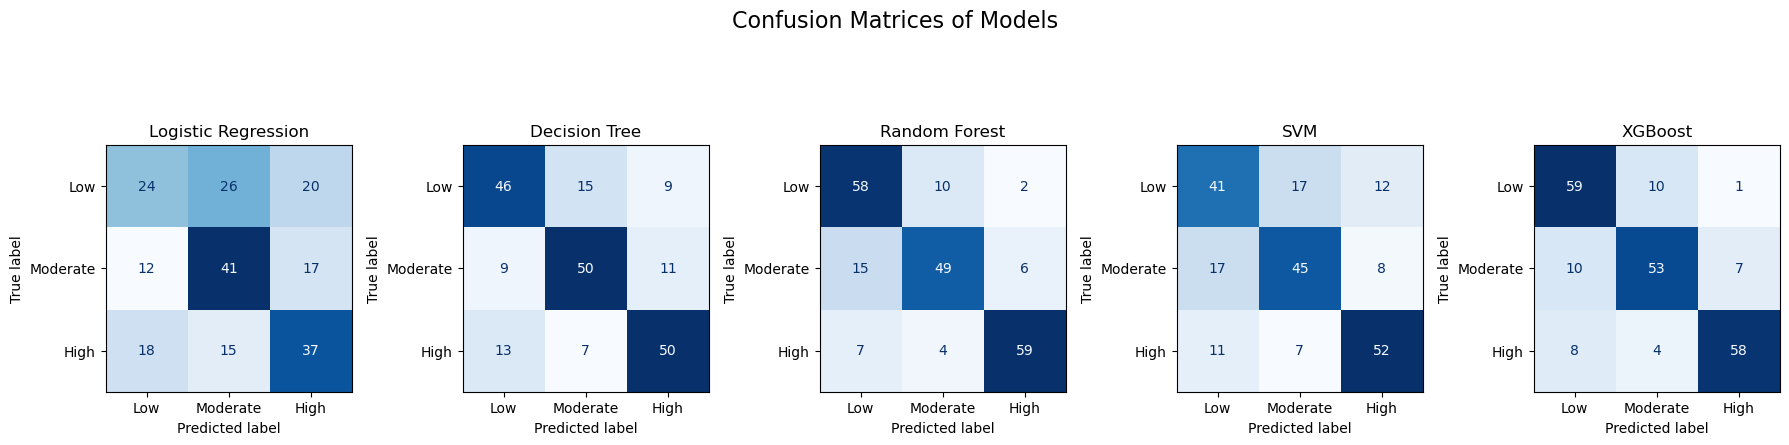

In [23]:
fig, axes = plt.subplots(1, len(models), figsize=(18, 5))  # one row, multiple columns

for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    # Print report in console
    print(f"\n===== {name} (Test Set) =====")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Moderate", "High"])
    disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)
    ax.set_title(f"{name}")

plt.suptitle("Confusion Matrices of Models", fontsize=16)
plt.tight_layout()
plt.show()

## 8. ROC-AUC Curves (Multiclass)

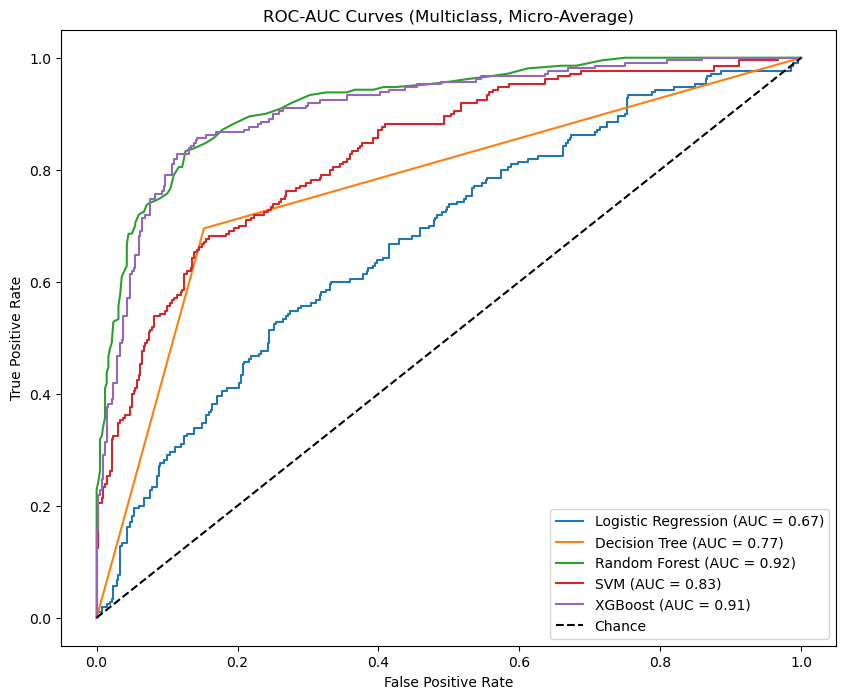

In [24]:
# Binarize labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 0=Low, 1=Moderate, 2=High
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Predict probabilities
    y_score = model.predict_proba(X_test)
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve (micro-average)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"{name} (AUC = {roc_auc['micro']:.2f})"
    )

# Plot random baseline
plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curves (Multiclass, Micro-Average)")
plt.legend(loc="lower right")
plt.show()
